In [81]:
import numpy as np
import pandas as pd
import yfinance as yf
import warnings
import riskfolio as rp
warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.4%}'.format

# Date range
start = '2016-01-01'
end = '2019-12-30'

# Tickers of assets
assets = ['JCI', 'TGT', 'CMCSA', 'CPB', 'MO', 'APA', 'MMC', 'JPM',
          'ZION', 'PSA', 'BAX', 'BMY', 'LUV', 'PCAR', 'TXT', 'TMO',
          'DE', 'MSFT', 'HPQ', 'SEE', 'VZ', 'CNP', 'NI', 'T', 'BA']
assets.sort()

# Downloading data
data = yf.download(assets, start = start, end = end)
data = data.loc[:,('Adj Close', slice(None))]
data.columns = assets

[*********************100%%**********************]  25 of 25 completed


In [82]:
# Calculating returns

Y = data[assets].pct_change().dropna()

display(Y.head())

,APA,BA,BAX,BMY,CMCSA,CNP,CPB,DE,HPQ,JCI,...,NI,PCAR,PSA,SEE,T,TGT,TMO,TXT,VZ,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-05,-2.0257%,0.4057%,0.4036%,1.9693%,0.0180%,0.9305%,0.3678%,0.5783%,0.9482%,-1.1953%,...,1.5881%,0.0212%,2.8236%,0.9758%,0.6987%,1.7539%,-0.1730%,0.2410%,1.3734%,-1.0857%
2016-01-06,-11.4863%,-1.5879%,0.2412%,-1.7557%,-0.7727%,-1.2473%,-0.1736%,-1.1239%,-3.5866%,-0.9551%,...,0.5547%,0.0212%,0.1592%,-1.5646%,0.3108%,-1.0155%,-0.7653%,-3.0048%,-0.9034%,-2.9145%
2016-01-07,-5.1389%,-4.1922%,-1.6573%,-2.7699%,-1.1047%,-1.9769%,-1.2206%,-0.8856%,-4.6059%,-2.5394%,...,-2.2066%,-3.0309%,-1.0411%,-3.1557%,-1.6148%,-0.2700%,-2.2845%,-2.0570%,-0.5492%,-3.0020%
2016-01-08,0.2736%,-2.2705%,-1.6037%,-2.5425%,0.1098%,-0.2241%,0.5707%,-1.6402%,-1.7641%,-0.1649%,...,-0.1539%,-1.1366%,-0.7307%,-0.1449%,0.0896%,-3.3839%,-0.1117%,-1.1387%,-0.9719%,-1.1254%
2016-01-11,-4.3384%,0.1692%,-1.6851%,-1.0215%,0.0915%,-1.1791%,0.5674%,0.5287%,0.6616%,0.0330%,...,1.6435%,0.0000%,0.9869%,-0.1450%,1.2224%,1.4570%,0.5367%,-0.4607%,0.5799%,-1.9919%


In [3]:
def calculate_portfolio_returns(daily_returns, weights):
    weighted_returns = daily_returns * weights.values
    portfolio_return = weighted_returns.sum(axis=1)
    cumulative_return = (1 + portfolio_return).cumprod() - 1
    df_returns = pd.DataFrame({
        'Daily Return': portfolio_return,
        'Cumulative Return': cumulative_return
    })
    return df_returns


In [97]:
port = rp.Portfolio(returns=Y)

# Calculating optimal portfolio

# Select method and estimate input parameters:

method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.

port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)

# Estimate optimal portfolio:

model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm = 'MV' # Risk measure used, this time will be variance
obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0 # Risk free rate
l = 0 # Risk aversion factor, only useful when obj is 'Utility'

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

display(w.T)

,APA,BA,BAX,BMY,CMCSA,CNP,CPB,DE,HPQ,JCI,...,NI,PCAR,PSA,SEE,T,TGT,TMO,TXT,VZ,ZION
weights,0.0000%,6.1590%,11.5018%,0.0000%,0.0000%,8.4806%,0.0000%,3.8193%,0.0000%,0.0000%,...,10.8262%,0.0000%,0.0000%,0.0000%,0.0000%,7.1804%,0.0001%,0.0000%,4.2736%,0.0000%


In [16]:
risk = ['MV', 'CVaR', 'MDD']
label = ['Std. Dev.', 'CVaR', 'Max Drawdown']
alpha = 0.05

for i in range(3):
    limits = port.frontier_limits(model=model, rm=risk[i], rf=rf, hist=hist)
    risk_min = rp.Sharpe_Risk(limits['w_min'], cov=cov, returns=returns, rm=risk[i], rf=rf, alpha=alpha)
    risk_max = rp.Sharpe_Risk(limits['w_max'], cov=cov, returns=returns, rm=risk[i], rf=rf, alpha=alpha)

    if 'Drawdown' in label[i]:
        factor = 1
    else:
        factor = 252**0.5

    print('\nMin Return ' + label[i] + ': ', (mu @ limits['w_min']).item() * 252)
    print('Max Return ' + label[i] + ': ',  (mu @ limits['w_max']).item() * 252)
    print('Min ' + label[i] + ': ', risk_min * factor)
    print('Max ' + label[i] + ': ', risk_max * factor)


Min Return Std. Dev.:  0.1297036978601279
Max Return Std. Dev.:  0.3121065491826169
Min Std. Dev.:  0.10376843039026933
Max Std. Dev.:  0.2193903131969613

Min Return CVaR:  0.11458947651046404
Max Return CVaR:  0.3121065492862288
Min CVaR:  0.2376269151572745
Max CVaR:  0.5141978305911208

Min Return Max Drawdown:  0.16948836511648338
Max Return Max Drawdown:  0.3121065492799967
Min Max Drawdown:  0.08596972094499988
Max Max Drawdown:  0.18506712308756956


In [18]:
rm = 'CVaR' # Risk measure
obj = 'Sharpe' # Objective function
# Constraint on maximum CVaR
l = 1 #

port.upperCVaR = 0.24/252**0.5 # We transform annual CVaR to daily CVaR

#rm = 'MV' obj = 'MinRisk' 2)
w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

display(w.T)

,APA,BA,BAX,BMY,CMCSA,CNP,CPB,DE,HPQ,JCI,...,NI,PCAR,PSA,SEE,T,TGT,TMO,TXT,VZ,ZION
weights,0.0000%,0.0000%,4.2576%,6.9536%,0.0000%,3.1555%,7.9285%,0.0000%,0.0000%,0.9571%,...,7.1652%,0.2313%,17.5181%,0.0000%,2.7780%,6.4176%,0.0000%,0.0000%,18.3498%,0.0000%


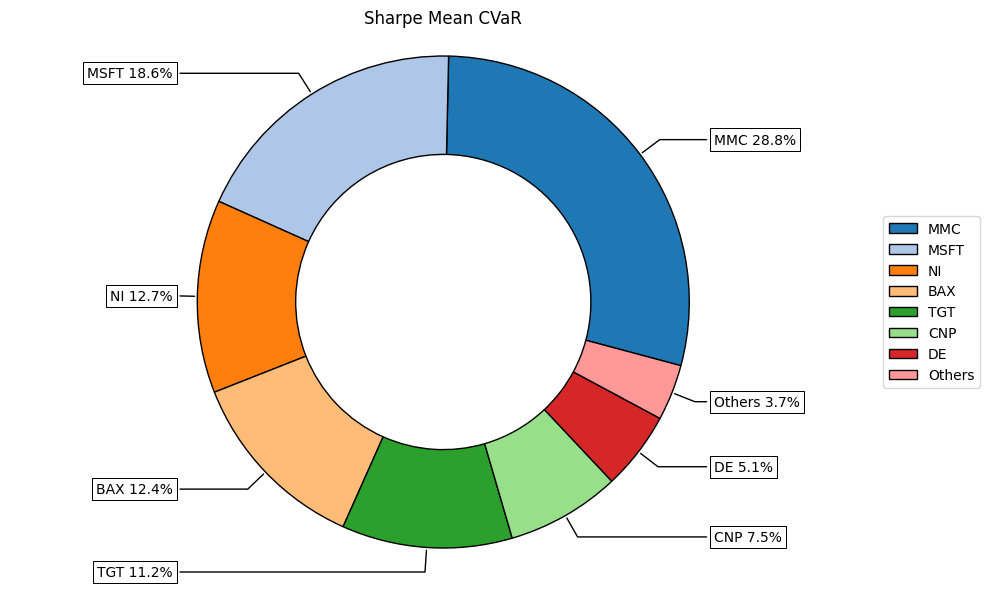

In [8]:
ax = rp.plot_pie(w=w, title='Sharpe Mean CVaR', others=0.05, nrow=25, cmap = "tab20",
                 height=6, width=10, ax=None)

In [9]:
port_test = calculate_portfolio_returns(Y, w.T)
stock = port_test['Daily Return']
df_new = pd.DataFrame((stock.sharpe(),
    stock.cvar(),
    stock.value_at_risk(),
    stock.var(),
    stock.volatility()))
df_new = df_new.T
df_new.columns = ['Sharpe', 'CVaR', 'VaR', 'Var', 'Volatility']
df = pd.concat([df, df_new])



AttributeError: 'Series' object has no attribute 'sharpe'

In [10]:
df

NameError: name 'df' is not defined

,AAPL,AMZN,BA,JPM,KO,MSFT,NVDA,TSLA
0,7.1620%,0.0000%,0.0000%,24.7184%,66.2881%,1.8314%,0.0000%,0.0000%
1,7.0143%,0.0000%,0.0000%,24.9186%,66.1096%,1.9575%,0.0000%,0.0000%
2,6.9881%,0.0000%,0.0000%,24.8513%,66.0347%,2.1260%,0.0000%,0.0000%
3,6.9941%,0.0000%,0.0000%,24.8233%,65.9470%,2.2357%,0.0000%,0.0000%
4,7.0253%,0.0000%,0.0000%,24.8260%,65.8492%,2.2994%,0.0000%,0.0000%


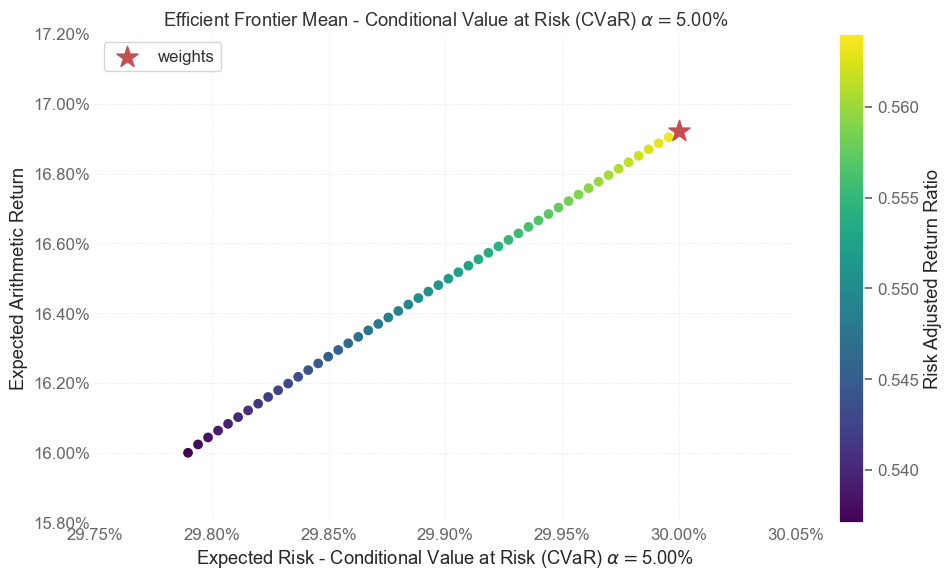

In [313]:
points = 50 # Number of points of the frontier

frontier = port.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)

display(frontier.T.head())

ax = rp.plot_frontier(w_frontier=frontier, mu=mu, cov=cov, returns=returns, rm='CVaR',
                      rf=rf, alpha=0.05, cmap='viridis', w=w, label=label,
                      marker='*', s=16, c='r', height=6, width=10, ax=None)

In [101]:

class PortfolioOptimizerTest:
    """
    This class is used to TEST optimize the portfolio using the risk-folio library
    """

    def __init__(self):
        self.weights_initial_sum = None
        self.assets = None
        self.cvar_value = None
        self.risk_level = None

    risk_level_user = {'Conservative': 1, 'Moderate': 2, 'Aggressive': 3}
    risk_level_default = 'Moderate'
    method_mu = 'hist'
    method_cov = 'hist'
    model = 'Classic'
    rm = 'CVaR'
    obj = 'Sharpe'
    hist = True
    rf = 0
    lib = 0
    
    def set_objective_function(self, objective: str):
        """
        sets the objective function
        :param objective: str
        :options: MinRisk, MaxRet, Utility, Sharpe
        :return: None
        """
        self.obj = objective
        return f'Objective function set in {obj}'
    
    def set_risk_level(self, risk_profile: str):
        """
        sets the risk level
        :param risk_profile: str
        :options: Conservative, Moderate, Aggressive
        :return: None
        """
        self.risk_level =  self.risk_level_user[risk_profile]
        if self.risk_level is not None:
            if self.risk_level == 1:
                self.set_objective_function('MinRisk')                
        return f'Risk level set in {risk_profile} and objective function set in {self.obj}'
    
   

    def set_initial_asset(self, assets, weights=None):
        """
        sets the initial assets and weights
        :param assets: list of assets
        :param weights: list of weights
        :return: None
        """

        if not isinstance(assets, (list, tuple)):
            raise TypeError("assets must be a list or tuple")

        if weights is not None and not isinstance(weights, (list, tuple)):
            raise TypeError('tuple or list expected for weights')

        if len(assets) != len(weights) if weights is not None else False:
            raise ValueError("length of assets and weights must be the same")

        self.assets = pd.DataFrame({'assets': assets, 'weights': weights})
        weights_initial_sum = self.assets['weights'].sum()
        self.weights_initial_sum = weights_initial_sum
        print('Initial weights sum: ', weights_initial_sum)

    def set_initial_cvar(self, cvar: int):
        cvar_value = cvar / 252 ** 0.5
        self.cvar_value = cvar_value
        return f'Cvar set in :{cvar}'

    def port_optimize(self, returns_train):
        port = rp.Portfolio(returns=returns_train)
        port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)
        if self.cvar_value is not None:
            try:
                port.upperCVaR = self.cvar_value
            except Exception as e:
                print(e)
        w = port.optimization(
            model=self.model,
            rm=self.rm,
            obj=self.obj,
            rf=self.rf,
            l=self.lib,
            hist=True)
        if self.weights_initial_sum is not None:
            try:
                w['weights'] = w['weights'] * (1 - self.weights_initial_sum)
                self.assets.set_index('assets', inplace=True)
                w = pd.concat([self.assets, w], axis=0)
            except Exception as e:
                print(e)
                
        return w

In [111]:
port = PortfolioOptimizerTest()
port.set_initial_cvar(0.24)

'Cvar set in :0.24'

In [112]:
port.port_optimize(Y)


,weights
APA,0.0000%
BA,0.0000%
BAX,4.2573%
BMY,6.9538%
CMCSA,0.0000%
CNP,3.1530%
CPB,7.9290%
DE,0.0000%
HPQ,0.0000%
JCI,0.9564%


In [113]:
port = PortfolioOptimizerTest()
port.set_risk_level('Conservative')

'Risk level set in Conservative and objective function set in MinRisk'

In [114]:
port.port_optimize(Y)


,weights
APA,0.0000%
BA,0.0000%
BAX,2.1562%
BMY,7.0922%
CMCSA,0.1947%
CNP,1.8683%
CPB,7.9952%
DE,0.0000%
HPQ,0.0000%
JCI,4.0581%
